# Training a Generative-Adversarial Network

In our previous chapters, we've focused on classification networks: taking an input and outputting a fixed label.  In this chapter, we'll examine generative networks: instead of simply classifying an image as containing a cat, these networks allow us to create new images of cats!  Cute lovers rejoice!

Most GAN research focuses on real life images from the CIFAR or ImageNet datasets.  For this section we'll pick a different type of image -- icons -- and see if we can generate realistic icons from scratch.

## Data collection

To train our GAN, we'll need a set of real icons to compare against.  Unfortunately, no such download is trivially available, so you'll have to do a little bit of manual work to acquire the data.

Start here: https://icons8.com/app/ and download the app.  Open up the resulting DMG image, right click, and select "Show Package Contents".  Now copy out the resources/icons.tar.gz file to somewhere on your file system and extract the contents.  We'll assume it's at ~/.cache/dl-cookbook/icons/.

On Linux and Windows, you can use 7z to extract the DMG contents and access icons.tar.gz


## Loading the data

Our icon data is store as a LevelDB database.  Python wrappers exist for LevelDB, making it easy to read.  Each icon record is in a custom format which we don't have a parser for.  We'll do our best to pull out the information we want: namely, the category and icon SVG itself.  Fortunately, the format appears to be consistent across the vast majority of the icons -- we ignore any icons we can't parse.

## Prepping our data

Before training our network, we want to normalize our data to make the models work a little easier: we'll normalize all of our images to have values between -1 and 1.  We'll also transform our categories we collected up above into labels from [0, num_labels].  We will use these labels to pre-train our discriminator network.

In [4]:
img_array = np.asarray(
    [2 * (img / (1e-9 + img.max()) - 0.5) for img in images]
)

# add a single dimension for our grayscale value, for compatibility with our models.
img_array = img_array[:,:,:,np.newaxis]

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(categories)

# Shuffle our data before processing it further.
shuffle_idx = np.arange(img_array.shape[0])
np.random.shuffle(shuffle_idx)
img_array = img_array[shuffle_idx]
category_labels = category_labels[shuffle_idx]

x_train = img_array

In [5]:
# Let's take a quick look at what our categories are like.

import collections
collections.Counter(categories)

# Trying CIFAR instead...

In [6]:
# from keras.datasets import cifar10

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# x_train -= 0.5
# x_test -= 0.5

## Building our network

Now that we have our icons, let's build our GAN network.  The basic idea with a GAN network is to construct 2 sub-networks that we will have "fight" against each other.

* Generator: this network starts with a random data seed, and it's goal is to generate an image that fools the discriminator
* Discriminator: this network is presented an image, and must decide whether it is a real image, or a fake generated by the generator network

By playing these networks against each other, we can cause the generator network to produce more and more convincing "fakes".

### Generator Network

Our generator network is effectively an upside down convolutional network.  Normal CNNs start with an image and producing a small dimensional label.  A generative network starts with a small random seed ("label"), and runs inverted CNN to produce successively larger images.

In [15]:
def adam():
    import keras.optimizers
    return keras.optimizers.Adam(lr=1e-4, beta_1=0.2)

In [12]:
import keras
from keras.models import Model
import keras.layers as L
import keras.backend as K
from keras.layers.merge import Concatenate

# Using https://github.com/ctmakro/hellotensor/blob/master/lets_gan_clean.py
# as a basis

def build_gen_network(seed_shape):
    input = L.Input(shape=(seed_shape,))
    reshaped = L.Reshape((1,1,seed_shape))(input)
    
    def deconv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2DTranspose(
            num_filters, (kernel_size, kernel_size), 
            padding=padding,
            strides=strides)(layer)
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.Activation('relu')(layer)
        return layer

    reshaped = deconv(reshaped, 192, 4, padding='valid', strides=1)
    reshaped = deconv(reshaped, 96, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 48, 4, padding='same', strides=2)
#     reshaped = deconv(reshaped, 24, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 3, 4, normalize=False, strides=2)    
    reshaped = L.Activation(activation='tanh')(reshaped)
    
    return Model(inputs=[input], outputs=[reshaped])

gen_net = build_gen_network(noise_size)
gen_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 4, 4, 192)         307392    
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 4, 192)         768       
_________________________________________________________________
activation_6 (Activation)    (None, 4, 4, 192)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 8, 8, 96)          295008    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 96)          384       
__________

### Discriminator Network

Our discriminator network is just a standard CNN, and looks like the inverse of our generator.  We stack a number of CNN layers, terminating in dense layer with a single output to decide if we are looking at a real or fake image.

In [9]:
def batch_discrimination(i):
    """
    GAN networks often end up with a generator that outputs the same image for every
    sample, fooling the discriminator.  This isn't very interesting behavior, so we
    give the generator an extra hint: the variance of the data across it's inputs.
    
    A batch where all of the images are the same will therefore look very suspicious
    and be weeded out quickly.
    """
    batch_variance = L.Lambda(lambda x: K.mean(K.abs(x[:] - K.mean(x,axis=0)),axis=-1,keepdims=True))(i)
    return Concatenate()([i,batch_variance])

def build_discriminator_network():
    input = L.Input(shape=(img_width, img_height, 3))
    def conv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2D(
            num_filters, kernel_size, 
            padding=padding,
            kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            strides=strides)(layer)
        
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
            layer = batch_discrimination(layer)
        
        return layer
    
    l = conv(input, 32, kernel_size=4, strides=2)
    l = conv(l, 64, kernel_size=4, strides=2)
    l = conv(l, 128, kernel_size=4, strides=2)
    l = conv(l, 256, kernel_size=4, strides=2)
    l = L.Flatten()(l)
    
    discriminator = L.Dense(units=1,activation='sigmoid')(l)
    return Model(inputs=[input], outputs=[discriminator])

dis_net = build_discriminator_network()
dis_net.compile(loss='binary_crossentropy', metrics=['accuracy'], 
                optimizer=adam())
dis_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 16, 16, 32)    1568        input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_5 (BatchNorm (None, 16, 16, 32)    128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 16, 16, 32)    0           batch_normalization_5[0][0]      
___________________________________________________________________________________________

## Combined Model

Now let's build the combined model which runs both our generator and discrimnator: this will be used for training.

In [13]:
# Disable training of the discriminator network for this step.
# Depending on the Keras version, we also disable/enable during training.
#
# We use the combined GAN network to train the generator portion only.
dis_net.trainable = False

latent = L.Input(shape=(noise_size, ))
generated = gen_net([latent])
g_score = dis_net(generated)

GAN = Model(inputs=[latent], outputs=[g_score])
GAN.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
GAN.summary()

dis_net.trainable = True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_4 (Model)              (None, 32, 32, 3)         679827    
_________________________________________________________________
model_2 (Model)              (None, 1)                 700261    
Total params: 1,380,088
Trainable params: 679,155
Non-trainable params: 700,933
_________________________________________________________________


## Training the GAN

Now we're finally ready to train the generator network.  We do this by alternating the following:

* Generate a batch of images G
* Train the discriminator to distinguish true images from G
* Generate a new batch G'
* Train the generator based on how well G' fooled the discriminator

  7800/ 7812 997.28 Dis(0.006834, 1.000000) Gen(4.775209, 0.000312)

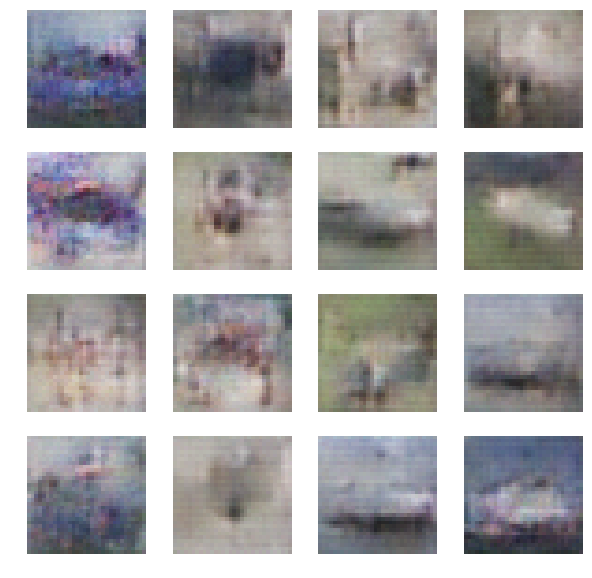

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf

import IPython
batch_size = 128
total_examples = 1000 * 1000

class Stat(object):
    def __init__(self, name):
        self._v = [(0, 0)]
        self.name = name
        
    def __repr__(self):
        return '%s(%0.6f, %0.6f)' % (self.name, self.loss(), self.accuracy())
    
    def record(self, v):
        self._v.append(v)
        
    def loss(self, last=50):
        return np.mean(self._v[-last:], axis=0)[0]
    
    def accuracy(self, last=50):
        return np.mean(self._v[-last:], axis=0)[1]
    
d_loss = Stat('Dis')
g_loss = Stat('Gen')
samples = []
import time

start = time.time()

np.random.shuffle(x_train)

for i in range(total_examples // batch_size):
    if i % 100 == 0:
        gen_img = gen_net.predict(np.random.normal(loc=0.,scale=1.,size=(16, noise_size)))
        gen_img *= 0.5
        gen_img += 0.5
        samples.append(gen_img[0])
        
        IPython.display.clear_output(wait=True)
        print('\r', '%5d/%5d %4.2f %s %s' % (
            i, total_examples/batch_size, time.time() - start, d_loss, g_loss),
              flush=True, end='')
            
        nb_utils.plot_images(gen_img)
        plt.show()

    # Train the discriminator network
    # Use separate batches for true and fake images    
    j = i % int(x_train.shape[0]/batch_size)
    image_batch = x_train[j:j+batch_size]
    gen_batch =  gen_net.predict(np.random.normal(loc=0.,scale=1.,size=(batch_size, noise_size)))
    
    dis_net.trainable = True
    d_loss.record(dis_net.train_on_batch(image_batch, np.ones(batch_size)))
    d_loss.record(dis_net.train_on_batch(gen_batch, np.zeros(batch_size)))
    dis_net.trainable = False
    
    
    # Now train the generator network -- it should generate inputs which
    # "fool" the discriminator and cause it to produce 1s.
    seed = np.random.normal(loc=0.,scale=1.,size=(2*batch_size, noise_size))
    g_loss.record(GAN.train_on_batch(seed, np.ones(2*batch_size)))

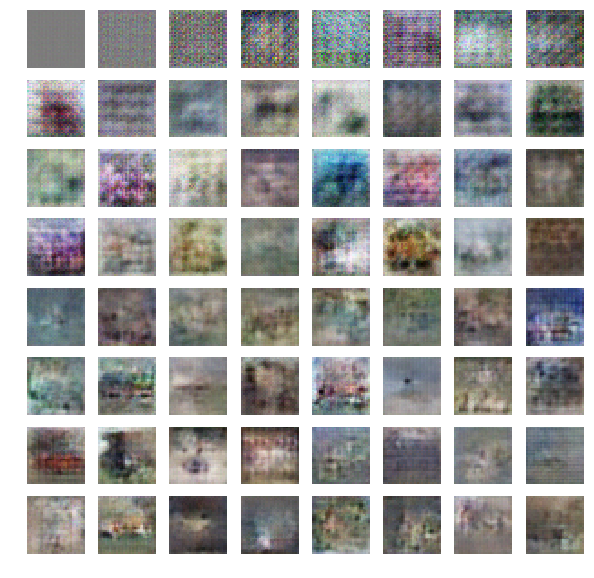

In [16]:
samples = np.asarray(samples)
n = (samples - samples.min()) / (samples.max() - samples.min())
nb_utils.plot_images(n)

In [17]:
import itertools, io
import numpy as np
import sys
from cairosvg import svg2png
import scipy.ndimage
from PIL import Image

noise_size = 100
img_width = 32
img_height = 32

import os
import nb_utils
DB_LOCATION = os.path.expanduser('~/.cache/dl-cookbook/icons/')

import leveldb
ldb = leveldb.LevelDB(DB_LOCATION)

l_iter = ldb.RangeIter(None, None)


def load_image(v):
    try:
        cat = v.replace(b'\x00', b'').split(b'\x08')[2].decode('utf8')
        
        start_idx = v.find(b'<?xml')
        end_idx = v.find(b'</svg>')
        v = v[start_idx:end_idx+6]    
        png = svg2png(bytestring=bytes(v))        
        
        with io.BytesIO(png) as f:
            img = Image.open(f)
            img.load()
            img = img.resize((img_width, img_height))
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3]) # 3 is the alpha channel
            img = background.convert('L')
            return np.asarray(img), cat
    except:
        print(sys.exc_info())
        return None

import multiprocessing
with multiprocessing.Pool() as pool:
    handles = []
    for k,v in l_iter:
        handles.append(pool.apply_async(load_image, (v,)))
    
    results = [h.get() for h in handles]
    results = [r for r in results if r is not None]
    images = [r[0] for r in results]
    categories = [r[1] for r in results]

LevelDBError: IO error: lock /home/power/.cache/dl-cookbook/icons//LOCK: already held by process

In [ ]:
%matplotlib inline
nb_utils.plot_images(images[:64])